# Porównanie rezulatów
## Autorzy:
- Jędrzej Warczyński 148234
- Uladzislau Abeziuk 150243

## Wykorzystane biblioteki

In [34]:
import cv2
import csv
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import keras
import pickle


from sklearnex import patch_sklearn
patch_sklearn()


from python_files.feature_extractor import FeatureExtractor
from python_files.recognition import preprocess, apply_fov_mask, segment_vessels
from python_files.metrics_visualizer import MetricsVisualizer
from python_files.constants import *

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Obrazy testowe

In [2]:
file_names.sort()
test_file_names = file_names[-5:]
print(test_file_names)

['14_g.jpg', '14_h.jpg', '15_dr.JPG', '15_g.jpg', '15_h.jpg']


## Wczytanie masek eskperckich

In [11]:
expert_masks = {}
for file in test_file_names:
    mask_name = file.split('.')[0] + '.tif'
    path = os.path.join(MANUAL_FOLDER, mask_name)
    expert_masks[file] = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

print(expert_masks[test_file_names[0]].shape)

(2336, 3504)


## Scieżki do modeli

In [ ]:
u_net_model_path = os.path.join(MODELS_FOLDER, "U_net_model_vessels")
random_forest_model_path = os.path.join(MODELS_FOLDER, "random_forest_model")

## Przygotowanie danych do predykcji przez model U-net

In [4]:
X_test = np.zeros((TEST_SIZE, *IMG_SHAPE), dtype=np.uint8)
Y_test = np.zeros((TEST_SIZE, *IMG_SHAPE[:2], 1), dtype=np.uint8)

for i, filename in tqdm(enumerate(test_file_names), total=TEST_SIZE):
  img_path = os.path.join(IMAGES_FOLDER, filename)
  manual_path = os.path.join(MANUAL_FOLDER, filename.split('.')[0] + '.tif')

  X_test[i] = cv2.imread(img_path)
  Y_test[i] = np.expand_dims(cv2.imread(manual_path, cv2.IMREAD_GRAYSCALE),-1)

100%|██████████| 5/5 [00:00<00:00, 10.41it/s]


In [15]:
print(X_test.shape)

(5, 2336, 3504, 3)


### Mała weryfikacja poprawności wczytania modelu

In [5]:
u_net_loaded_model = keras.models.load_model(u_net_model_path)
_, loaded_accuracy = u_net_loaded_model.evaluate(X_test, Y_test, batch_size=1)
loaded_accuracy

5/5 [==============================] - 16s 3s/step - loss: -14.6978 - accuracy: 0.9151


0.9151469469070435

## Predykcja przez model U-net

In [6]:
loaded_model_predictions = u_net_loaded_model.predict(X_test, batch_size=1)
loaded_model_predictions.shape

5/5 [==============================] - 16s 3s/step


(5, 2336, 3504, 1)

## Przygotowanie predykcji do porównania (transofrmacja wymiarów normalizacja do 0-255)

In [7]:
predictions_pixels = (loaded_model_predictions > 0.5).astype(np.uint8)
predictions_pixels.shape

(5, 2336, 3504, 1)

In [8]:
prediction_masks = {}
for i, test_file_name in enumerate(test_file_names):
    reshaped_prediction = np.reshape(predictions_pixels[i], IMG_SHAPE[:2])
    reshaped_prediction = reshaped_prediction * 255
    prediction_masks[test_file_name] = reshaped_prediction

print(prediction_masks[test_file_names[0]].shape)

(2336, 3504)


## Wyznaczenie metryk dla modelu U-net

In [ ]:
metrics = MetricsVisualizer()
for file in test_file_names:
    metrics.calculate_metrics(expert_masks[file], prediction_masks[file], file)

## Wczytanie modelu lasu losowego

In [0]:
random_forest_model = pickle.load(open(random_forest_model_path, 'rb'))
rfc_preprocessed_test_images = []
rfc_test_features = []

## Przygotowanie danych do predykcji przez model lasu losowego - ekstrackcja cech

In [20]:
for test_img in tqdm(X_test, total=TEST_SIZE):
    rfc_preprocessed_test_image = preprocess(test_img)
    rfc_preprocessed_test_images.append(rfc_preprocessed_test_image)
    test_img_feature_extractor = FeatureExtractor(rfc_preprocessed_test_image)
    rfc_test_features.append(test_img_feature_extractor.extract_features())

100%|██████████| 5/5 [00:29<00:00,  5.84s/it]


## Predykcja przez model lasu losowego

In [22]:
random_forest_masks = []
for i, test_feature in tqdm(enumerate(rfc_test_features), total=5):
    test_img_segmented = random_forest_model.predict(test_feature)
    test_img_segmented = test_img_segmented.reshape(X_test[i].shape[:2])
    # test_img_segmented = apply_fov_mask(test_img_segmented, test_fov_masks[i])
    random_forest_masks.append(test_img_segmented)

100%|██████████| 5/5 [12:41<00:00, 152.31s/it]


## Wyznaczenie metryk dla modelu lasu losowego

In [ ]:
rfc_metrics = MetricsVisualizer()
for i, file in enumerate(test_file_names):
    rfc_metrics.calculate_metrics(expert_masks[file], random_forest_masks[i], file)

## Segmentacja tradycyjnymi metodami i obliczenie metryk

In [26]:
std_method_metrics_visualizer = MetricsVisualizer()
std_method_masks = []
for i, file_name in tqdm(enumerate(test_file_names), total=5):
    fov_mask_path = os.path.join(MASK_FOLDER, file_name.split('.')[0] + '_mask.tif')
    fov_mask = cv2.imread(fov_mask_path, cv2.IMREAD_GRAYSCALE)

    segmentation_mask = segment_vessels(X_test[i], fov_mask)
    std_method_masks.append(segmentation_mask)
    std_method_metrics_visualizer.calculate_metrics(expert_masks[file_name], segmentation_mask, file_name)

100%|██████████| 5/5 [01:23<00:00, 16.69s/it]


In [29]:
accuracies = [std_method_metrics_visualizer.accuracy, rfc_metrics.accuracy, metrics.accuracy]
sensitivities = [std_method_metrics_visualizer.sensitivity, rfc_metrics.sensitivity, metrics.sensitivity]
specificities = [std_method_metrics_visualizer.specificity, rfc_metrics.specificity, metrics.specificity]

## Wizualizacja porównawcza metryk

In [30]:
def bar_plot(ax, data, filenames, labels, title, ylabel):
    width = 0.20
    ind = np.arange(len(filenames))

    rects1 = ax.bar(ind - width, data[0], width, label=labels[0])
    rects2 = ax.bar(ind, data[1], width, label=labels[1])
    rects2 = ax.bar(ind + width, data[2], width, label=labels[2])

    ax.set_xticks(ind)
    ax.set_xticklabels(filenames)

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if ylabel == "Accuracy":
        ax.legend(loc='upper center', bbox_to_anchor=(1.70, -0.07))

    return ax

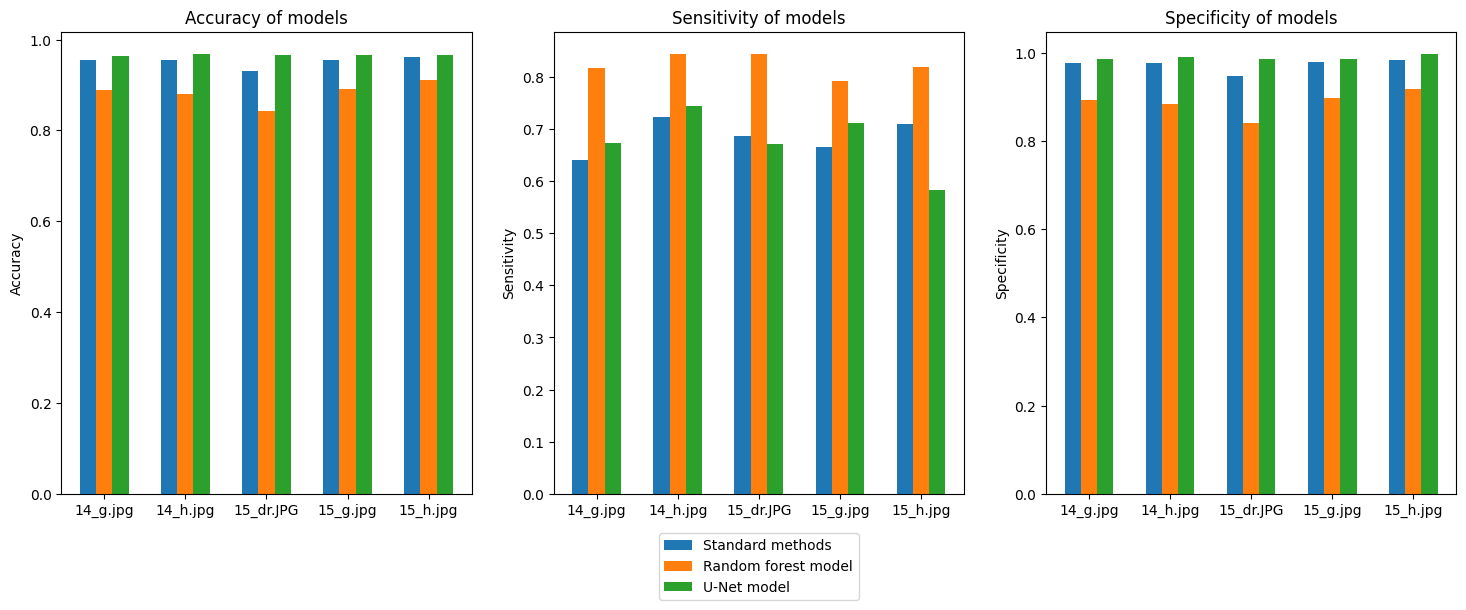

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
filenames = expert_masks.keys()
labels = ["Standard methods", "Random forest model", "U-Net model"]
title = "Accuracy of models"

bar_plot(axes[0], accuracies, test_file_names, labels, "Accuracy of models", "Accuracy")
bar_plot(axes[1], sensitivities, test_file_names, labels, "Sensitivity of models", "Sensitivity")
bar_plot(axes[2], specificities, test_file_names, labels, "Specificity of models", "Specificity")
plt.show()

## Zapisanie metryk do pliku

In [39]:
result_path = os.path.join(RESULTS_FOLDER, "metrics.csv")
methods = ["Traditional_methods", "Random_forest_model", "U_Net_model"]

with open(result_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    headers = ['Model', 'File', 'Accuracy', 'Sensitivity', 'Specificity']
    writer.writerow(headers)

    for i in range(len(accuracies)):
        model_name = methods[i]
        accuracy_values = accuracies[i]
        sensitivity_values = sensitivities[i]
        specificity_values = specificities[i]

        for j in range(len(test_file_names)):
            file_name = file_names[j]
            accuracy = accuracy_values[j]
            sensitivity = sensitivity_values[j]
            specificity = specificity_values[j]

            row = [model_name, file_name, accuracy, sensitivity, specificity]
            writer.writerow(row)

## Podsumowanie

W analizie trzech modeli: Tradycyjny model przetwarzania obrazu, Random Forest Model i U-Net Model, wszystkie modele wykazały wysoką dokładność w przewidywaniu wyników na podstawie analizy obrazów.

Model Tradycyjny osiągnął średnią dokładność na poziomie około 95%. Czułość tego modelu wahają się między 64% a 72%, co oznacza, że był w stanie poprawnie zidentyfikować większość pozytywnych przypadków. Wartości specyficzności dla tego modelu wynosiły średnio powyżej 97%, co sugeruje, że był on skuteczny w identyfikacji negatywnych przypadków, co jednak wynika z dużego nizbalansowania dancyh.

Random Forest Model osiągnął nieco niższą średnią dokładność, wynoszącą około 89%. Jednak wartości czułości dla tego modelu były wyraźnie wyższe, oscylujące wokół 81%. Wartości specyficzności utrzymywały się na poziomie powyżej 88%. Oznacza to, że model ten był bardziej skłonny do klasyfikowania przypadków jako negatywne, co wpływało na jego czułość.

Najlepsze wyniki dokładności uzyskano dla modelu U-Net, który osiągnął wysoką dokładność na poziomie powyżej 96%. Model ten wykazał również wysoką czułość, wynoszącą około 69%. Wartości specyficzności dla tego modelu utrzymywały się na poziomie powyżej 98%. Może to sugerować, że model U-Net był skuteczny zarówno w identyfikacji pozytywnych przypadków, jak i negatywnych przypadków.

Podsumowując, wydaję się, że model U-net zdominował model Random Forest, dla wszytskich metryk jego wyniki było średnio wyżśze od mmodelu Random Forest, tylko w kilku przypadkach wyniki były gorsze.
Tradycyjne metody przetwarzania obrazu wykazały się za to najlepszą czułością, jednak dokładność i specyficzność były niższe niż w przypadku modeli opartych o uczenie maszynowe.